In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 1. Setup & Data Loading

In [2]:
from utils.movie_data_loader import MovieDataLoader
from models.supervised.feature_engineering import FeatureEngineer

print("Loading data...")
loader = MovieDataLoader()
df_raw = loader.get_supervised_data()

print("Engineering features...")
engineer = FeatureEngineer()
df_processed = engineer.create_all_features(df_raw)
X, y = engineer.prepare_features_and_target(df_processed)
X_scaled = engineer.fit_transform(X)

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.2, random_state=42
)

print(f"\nData Shapes:")
print(f"  Training set:  {len(X_train)} samples")
print(f"  Test set:      {len(X_test)} samples")
print(f"  Features:      {X.shape[1]}")

Loading data...
Engineering features...
Splitting data...

Data Shapes:
  Training set:  8142 samples
  Test set:      2036 samples
  Features:      29


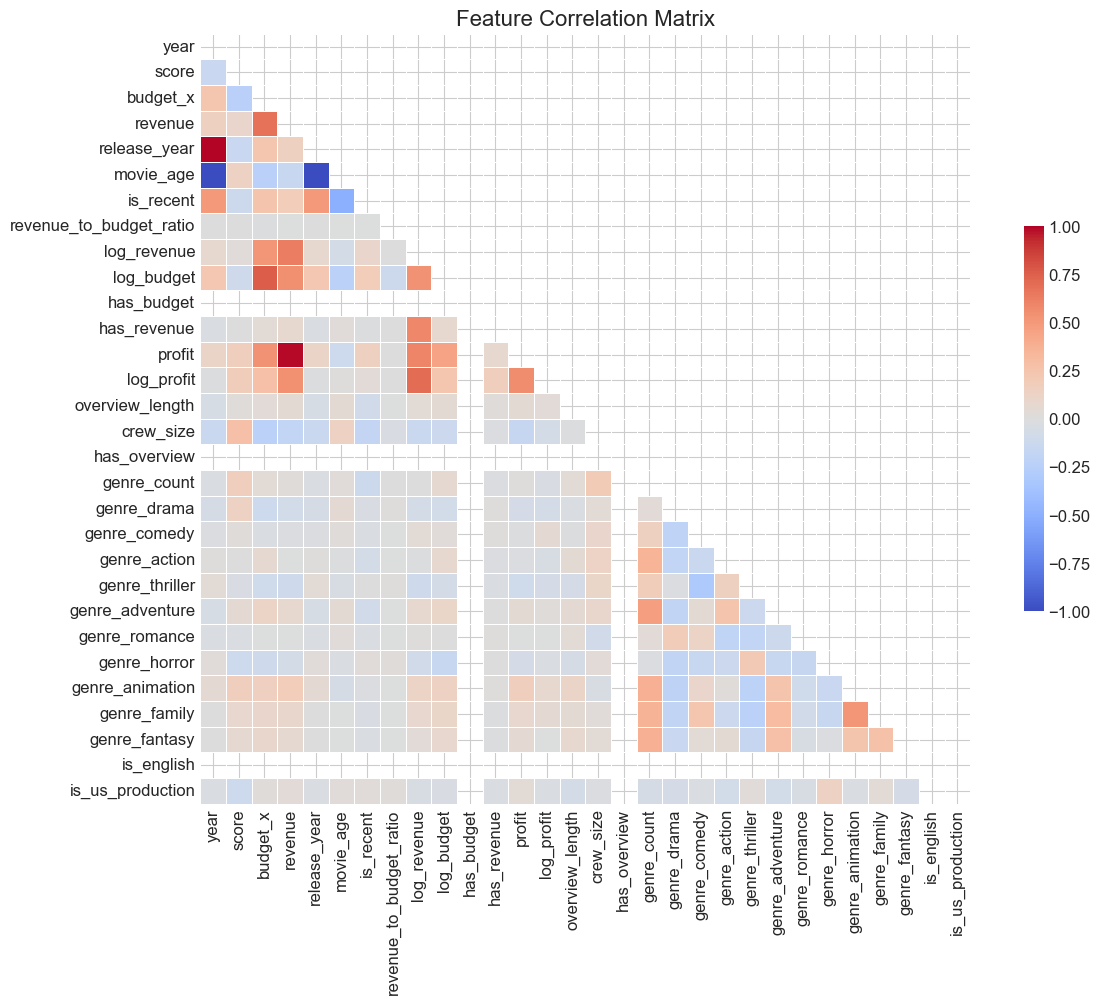

In [3]:
plt.figure(figsize=(14, 10))
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
corr = df_processed[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

## 2. Visualization Utilities

In [4]:
def plot_learning_curve_graph(estimator, title, X, y, cv=5):
    """
    Generates a Learning Curve to diagnose Bias vs Variance.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve: {title}")
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def plot_diagnostics(model, X_train, y_train, y_pred, title):
    """
    Generates Predicted vs Actual and Residual plots.
    """
    residuals = y_train - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.scatterplot(x=y_train, y=y_pred, alpha=0.5, ax=axes[0])
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Score')
    axes[0].set_ylabel('Predicted Score')
    axes[0].set_title(f'{title}: Predicted vs Actual')
    
    sns.histplot(residuals, kde=True, ax=axes[1], color='orange')
    axes[1].set_xlabel('Residuals (Actual - Predicted)')
    axes[1].set_title(f'{title}: Residual Distribution')
    axes[1].axvline(0, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()

## 3. Linear Regression

Linear Regression CV R²:   0.2986 (+/- 0.0565)
Linear Regression CV RMSE: 11.4520
Prediction Accuracy (±5 pts):  43.5%
Prediction Accuracy (±10 pts): 73.5%


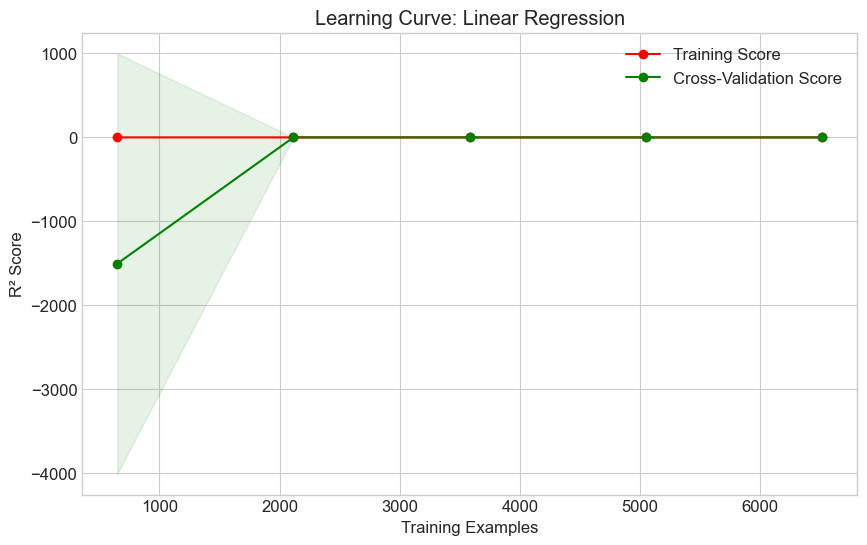

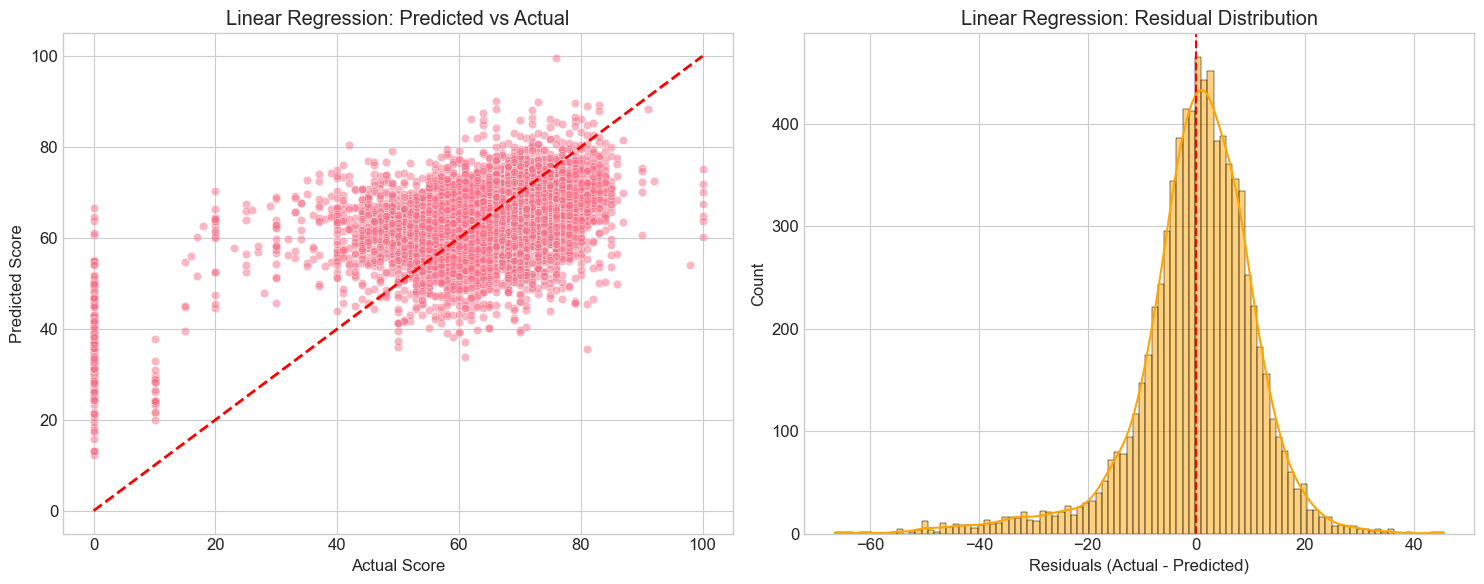

In [5]:
lr = LinearRegression()

cv_results_lr = cross_validate(lr, X_train, y_train, cv=5, 
                               scoring=['r2', 'neg_root_mean_squared_error'],
                               return_train_score=True)

print(f"Linear Regression CV R²:   {cv_results_lr['test_r2'].mean():.4f} (+/- {cv_results_lr['test_r2'].std():.4f})")
print(f"Linear Regression CV RMSE: {-cv_results_lr['test_neg_root_mean_squared_error'].mean():.4f}")

lr.fit(X_train, y_train)
y_pred_temp = lr.predict(X_train)
errors = np.abs(y_train - y_pred_temp)
acc_5 = (errors <= 5).sum() / len(errors) * 100
acc_10 = (errors <= 10).sum() / len(errors) * 100
print(f"Prediction Accuracy (±5 pts):  {acc_5:.1f}%")
print(f"Prediction Accuracy (±10 pts): {acc_10:.1f}%")

plot_learning_curve_graph(lr, "Linear Regression", X_train, y_train)

lr.fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)
plot_diagnostics(lr, X_train, y_train, y_train_pred_lr, "Linear Regression")

## 4. Ridge Regression

Ridge Regression CV R²:   0.2995 (+/- 0.0550)
Ridge Regression CV RMSE: 11.4448
Prediction Accuracy (±5 pts):  43.5%
Prediction Accuracy (±10 pts): 73.5%


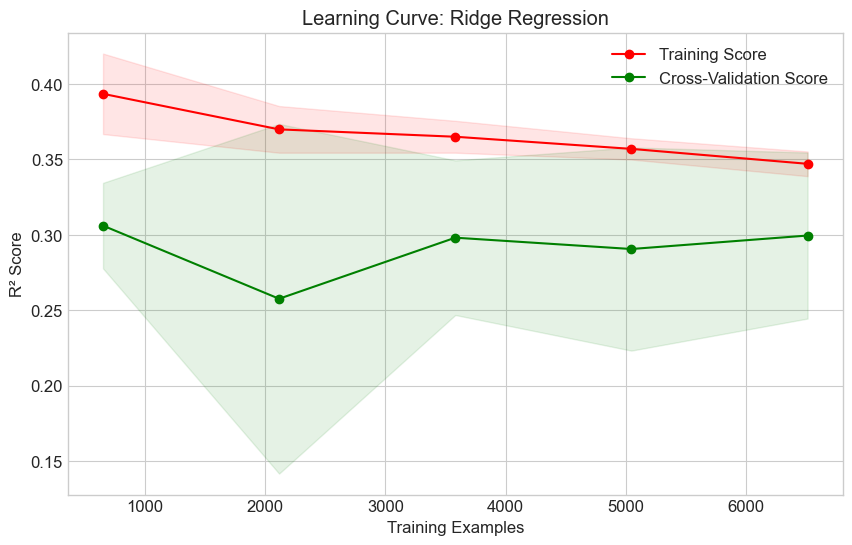

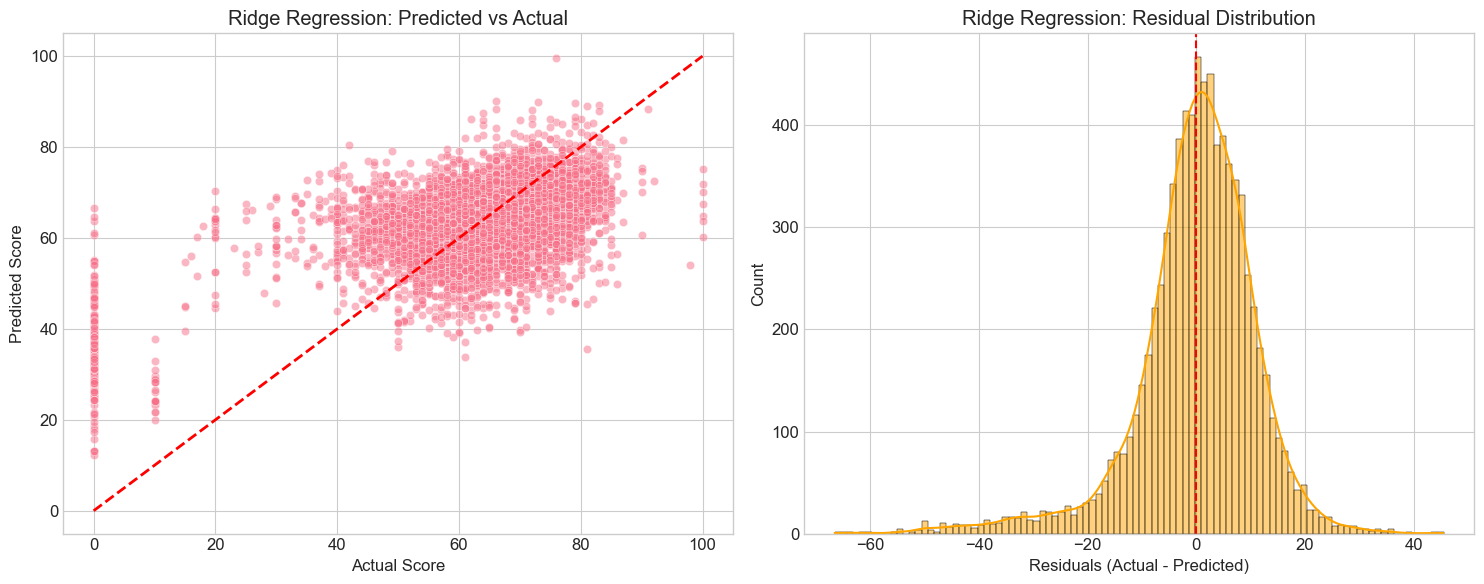

In [6]:
ridge = Ridge(alpha=1.0)

cv_results_ridge = cross_validate(ridge, X_train, y_train, cv=5, 
                                  scoring=['r2', 'neg_root_mean_squared_error'],
                                  return_train_score=True)

print(f"Ridge Regression CV R²:   {cv_results_ridge['test_r2'].mean():.4f} (+/- {cv_results_ridge['test_r2'].std():.4f})")
print(f"Ridge Regression CV RMSE: {-cv_results_ridge['test_neg_root_mean_squared_error'].mean():.4f}")

ridge.fit(X_train, y_train)
y_pred_temp = ridge.predict(X_train)
errors = np.abs(y_train - y_pred_temp)
acc_5 = (errors <= 5).sum() / len(errors) * 100
acc_10 = (errors <= 10).sum() / len(errors) * 100
print(f"Prediction Accuracy (±5 pts):  {acc_5:.1f}%")
print(f"Prediction Accuracy (±10 pts): {acc_10:.1f}%")

plot_learning_curve_graph(ridge, "Ridge Regression", X_train, y_train)

ridge.fit(X_train, y_train)
y_train_pred_ridge = ridge.predict(X_train)
plot_diagnostics(ridge, X_train, y_train, y_train_pred_ridge, "Ridge Regression")

## 5. Random Forest

Random Forest CV R²:   0.6622 (+/- 0.0451)
Random Forest CV RMSE: 7.9097
Prediction Accuracy (±5 pts):  71.3%
Prediction Accuracy (±10 pts): 95.1%


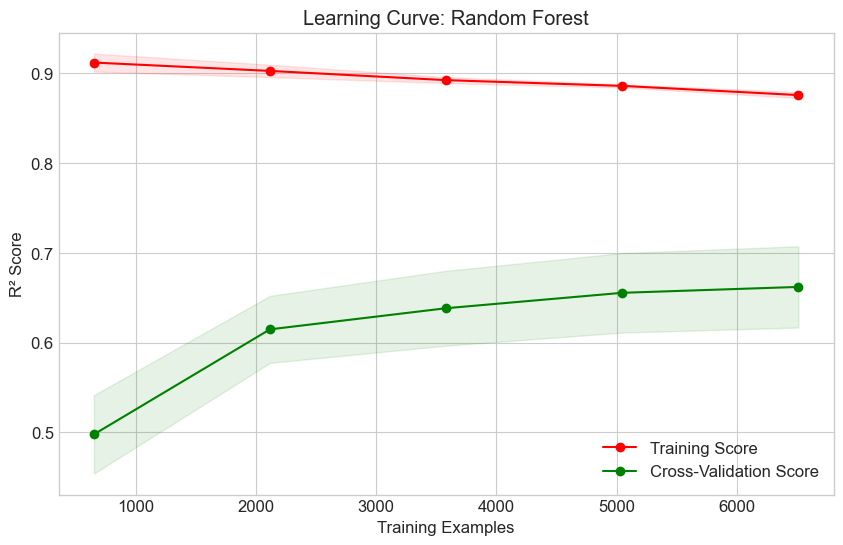

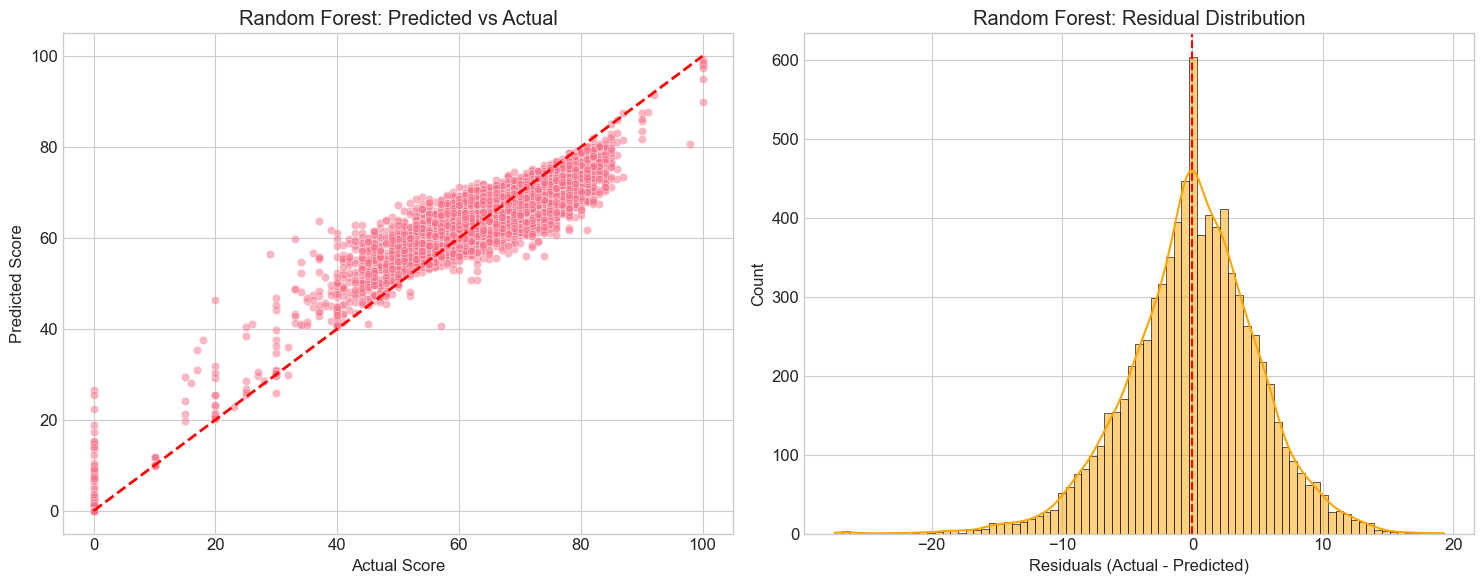

In [7]:
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)

cv_results_rf = cross_validate(rf, X_train, y_train, cv=5, 
                                  scoring=['r2', 'neg_root_mean_squared_error'],
                                  return_train_score=True)

print(f"Random Forest CV R²:   {cv_results_rf['test_r2'].mean():.4f} (+/- {cv_results_rf['test_r2'].std():.4f})")
print(f"Random Forest CV RMSE: {-cv_results_rf['test_neg_root_mean_squared_error'].mean():.4f}")

rf.fit(X_train, y_train)
y_pred_temp = rf.predict(X_train)
errors = np.abs(y_train - y_pred_temp)
acc_5 = (errors <= 5).sum() / len(errors) * 100
acc_10 = (errors <= 10).sum() / len(errors) * 100
print(f"Prediction Accuracy (±5 pts):  {acc_5:.1f}%")
print(f"Prediction Accuracy (±10 pts): {acc_10:.1f}%")

plot_learning_curve_graph(rf, "Random Forest", X_train, y_train)

rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
plot_diagnostics(rf, X_train, y_train, y_train_pred_rf, "Random Forest")

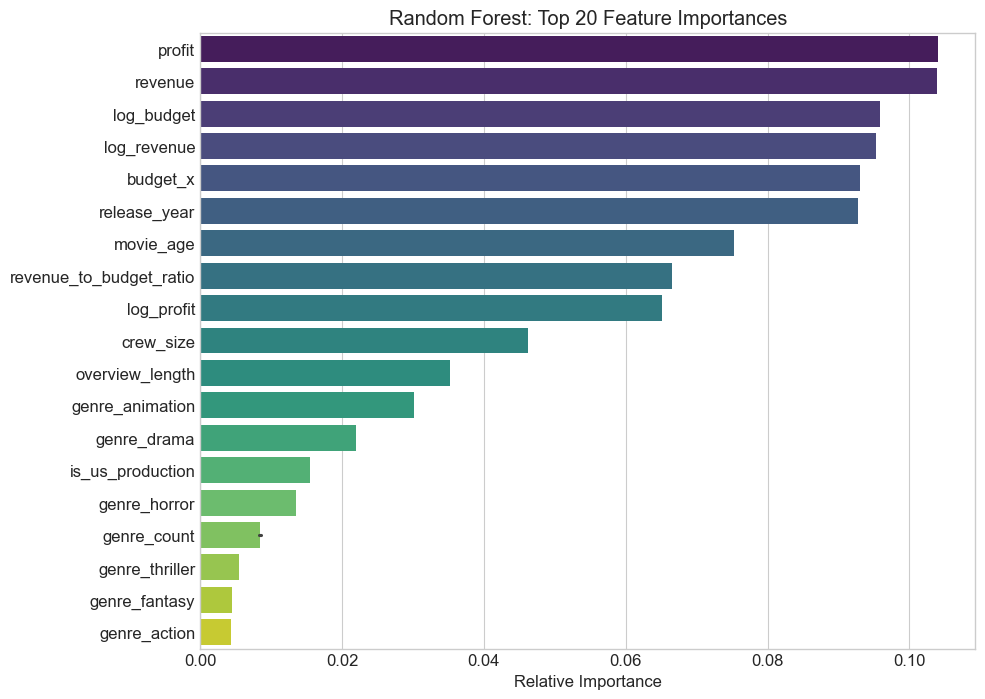

In [8]:
plt.figure(figsize=(10, 8))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]

sns.barplot(x=importances[indices], y=[engineer.feature_names[i] for i in indices], palette="viridis")
plt.title("Random Forest: Top 20 Feature Importances")
plt.xlabel("Relative Importance")
plt.show()

## 6. Model Comparison & Selection

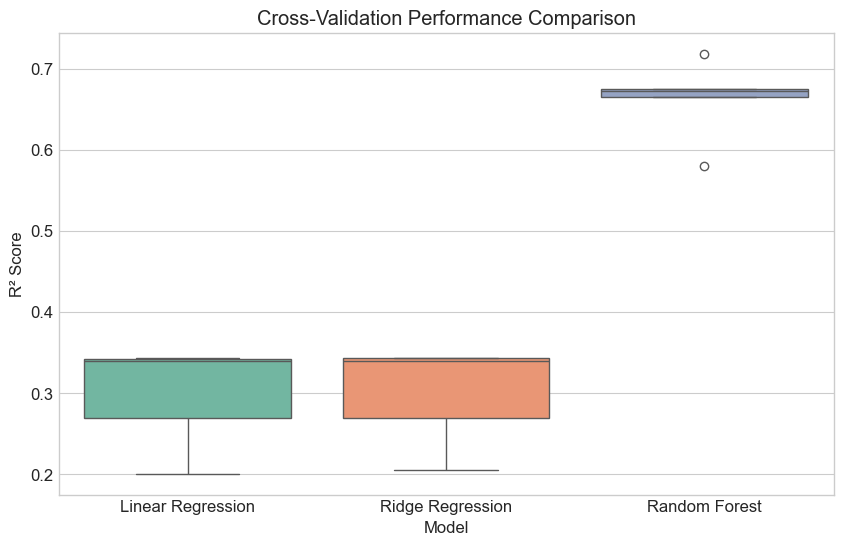

Average R² Scores:
Model
Linear Regression    0.298636
Random Forest        0.662173
Ridge Regression     0.299509
Name: R2 Score, dtype: float64

Best Model: Random Forest


In [9]:
results_df = pd.DataFrame({
    'Model': ['Linear Regression']*5 + ['Ridge Regression']*5 + ['Random Forest']*5,
    'R2 Score': np.concatenate([cv_results_lr['test_r2'], cv_results_ridge['test_r2'], cv_results_rf['test_r2']])
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='R2 Score', data=results_df, palette="Set2")
plt.title("Cross-Validation Performance Comparison")
plt.ylabel("R² Score")
plt.show()

mean_scores = results_df.groupby('Model')['R2 Score'].mean()
winner = mean_scores.idxmax()
print(f"Average R² Scores:\n{mean_scores}")
print(f"\nBest Model: {winner}")

## 7. Hyperparameter Optimization

In [10]:
best_model_name = winner

print("Tuning Random Forest...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
    
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
    
final_model = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV Score: {grid.best_score_:.4f}")

Tuning Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score: 0.6607


## 8. Final Test Set Evaluation

FINAL TEST SET RESULTS
R² Score: 0.6218
RMSE:     7.9082
MAE:      5.7089


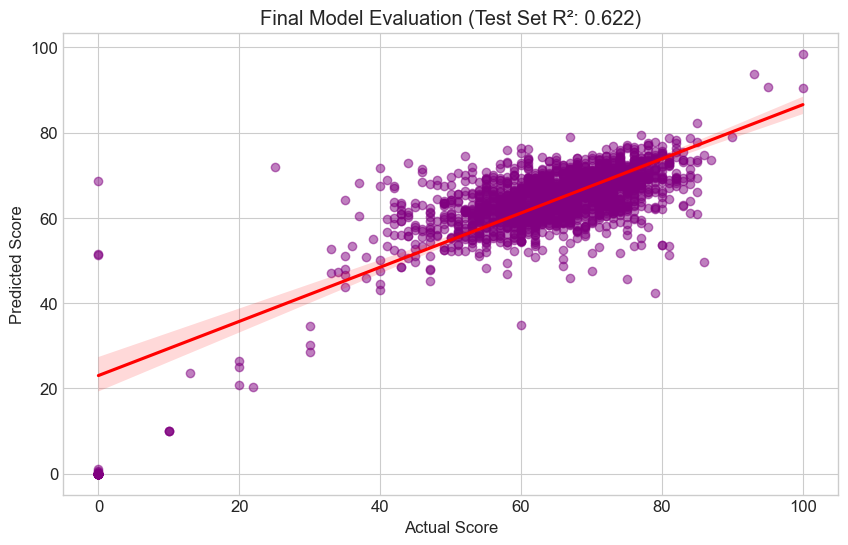

In [11]:
y_test_pred = final_model.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"FINAL TEST SET RESULTS")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE:     {test_rmse:.4f}")
print(f"MAE:      {test_mae:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'alpha':0.5, 'color':'purple'}, line_kws={'color':'red'})
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title(f"Final Model Evaluation (Test Set R²: {test_r2:.3f})")
plt.show()